In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

In [3]:
x_train = train_data.drop(['id', 'target'], axis = 1)
y_train = train_data['target']

In [4]:
del train_data

In [5]:
test_data = test_data.drop(['id'], axis = 1)

In [6]:
y_train.value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [7]:
x_train.shape

(250, 300)

In [8]:
def create_model():
    model = Sequential()
    
    model.add(Dense(300, input_shape = (300,)))
    
    model.add(Dense(512, activation = 'relu', use_bias = True))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation = 'relu', use_bias = True))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation = 'relu', use_bias = True))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

def train_model(model, x_train, y_train, train_step_size, callbacks):
    
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    history = model.fit(x_train, 
                        y_train,
                        epochs = 50,
                        steps_per_epoch = train_step_size,
                        verbose = 1,
                        callbacks = callbacks)
    return history

In [9]:
weights_file_path = 'dont-overfit-weights.h5'

reduce_learning_rate = ReduceLROnPlateau(monitor = 'acc', patience = 3, verbose = 1, factor = 0.75, min_lr = 0.00001)
checkpoint = ModelCheckpoint(weights_file_path, monitor = 'acc', verbose = 1, save_best_only = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1, restore_best_weights = True)

callbacks = [reduce_learning_rate, checkpoint, early_stopping]

batch_size = 8

train_step_size = x_train.shape[0] // batch_size

In [10]:
model = create_model()

history = train_model(model, x_train, y_train, train_step_size, callbacks)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
31/31 [==============================] - 2s 67ms/step - loss: 0.2673 - acc: 0.8794

Epoch 00001: acc improved from -inf to 0.87935, saving model to dont-overfit-weights.h5
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0157 - acc: 0.9977

Epoch 00002: acc improved from 0.87935 to 0.99768, saving model to dont-overfit-weights.h5
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - acc: 1.0000

Epoch 00003: acc improved from 0.99768 to 1.00000, saving model to dont-overfit-weights.h5
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 7.0444e-04 - acc: 1.0000

Epoch 00004: acc did not improve from 1.00000
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - lo

In [11]:
predict_model = create_model()
predict_model.load_weights(weights_file_path)

predictions = predict_model.predict(test_data)

In [12]:
def plot_training_curves(history):
    acc = history.history['acc']
    loss = history.history['loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.figure()
    
    plt.show()

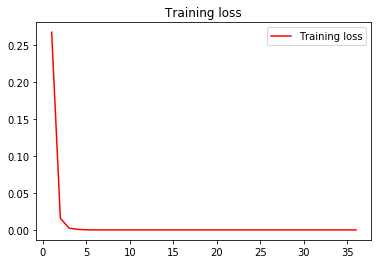

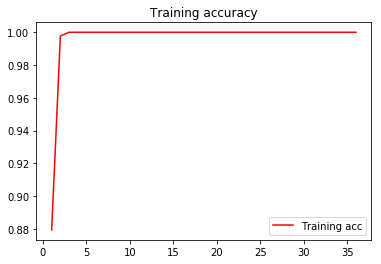

<Figure size 432x288 with 0 Axes>

In [13]:
plot_training_curves(history)

In [14]:
ps = []
for i, value in enumerate(predictions):
    ps.append(value[0])

#predictions = np.argmax(predictions, axis = 1)

predictions = pd.Series(ps, name = "target")

submission = pd.concat([pd.Series(range(250, 20000), name = "id"), predictions], axis = 1)

submission.to_csv("dont-overfit-submission.csv", index = False)

In [15]:
print(submission['target'].sum() / len(submission))

0.6277522719607879
